In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import re

pd.set_option('display.max_columns', None)

In [2]:
WORKING_DIRECTORY = '../data/'

## Basic data validation

In [3]:
conn = sqlite3.Connection(WORKING_DIRECTORY + '/processed/fire_data.db')

Here we want to use CITY, STATE, INCIDENT KEY, INC_DATE, and INC_TYPE. We'll check the number of null values in these columns for incident_address and basic_incident.

In [4]:
display(pd.read_sql("""
    SELECT 
        COUNT(*) - COUNT(CITY) AS CITY_NULL,
        COUNT(*) - COUNT(STATE) AS STATE_NULL,
        COUNT(*) - COUNT(INCIDENT_KEY) AS INCIDENT_KEY_NULL,
        COUNT(*) - COUNT(INC_DATE) AS INC_DATE_NULL
    FROM incident_address;
""", conn))

display(pd.read_sql("""
    SELECT 
        COUNT(*) - COUNT(INCIDENT_KEY) AS INCIDENT_KEY_NULL,
        COUNT(*) - COUNT(INC_DATE) AS INC_DATE_NULL,
        COUNT(*) - COUNT(INC_TYPE) AS INC_TYPE_NULL
    FROM basic_incident;
""", conn))

,CITY_NULL,STATE_NULL,INCIDENT_KEY_NULL,INC_DATE_NULL
0,0,0,0,0


,INCIDENT_KEY_NULL,INC_DATE_NULL,INC_TYPE_NULL
0,0,0,0


Check the types of incident codes in the dataset.

In [5]:
query = """
    SELECT
        CASE
            WHEN INC_TYPE BETWEEN 100 AND 199 THEN '100-199'
            WHEN INC_TYPE BETWEEN 200 AND 299 THEN '200-299'
            WHEN INC_TYPE BETWEEN 300 AND 399 THEN '300-399'
            WHEN INC_TYPE BETWEEN 400 AND 499 THEN '400-499'
            WHEN INC_TYPE BETWEEN 500 AND 599 THEN '500-599'
            WHEN INC_TYPE BETWEEN 600 AND 699 THEN '600-699'
            WHEN INC_TYPE BETWEEN 700 AND 799 THEN '700-799'
            WHEN INC_TYPE BETWEEN 800 AND 899 THEN '800-899'
            ELSE 'Other'
        END AS INC_TYPE_RANGE,
        COUNT(*) AS COUNT
    FROM
        basic_incident
    GROUP BY
        INC_TYPE_RANGE;
"""

pd.read_sql(query, conn)

,INC_TYPE_RANGE,COUNT
0,100-199,8776719
1,400-499,7346206
2,500-599,822846
3,600-699,472987


# Total incident counts by city

We'll only count rows with INC_TYPE under 200, which indicates a fire. We'll also limit ourselves to data before 2019, because we'll use 2020 later for validation.

In [6]:
# 4 minutes to run
total_incidents = pd.read_sql("""
    SELECT 
        ia.CITY || ',' || ia.STATE AS CITYSTATE, 
        COUNT(bi.ID) AS INC_COUNT
    FROM basic_incident bi 
        JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200
        AND CAST(SUBSTR(ia.INC_DATE, LENGTH(ia.INC_DATE) - 3, 4) AS INTEGER) < 2019
    GROUP BY ia.CITY, ia.STATE
""", conn)

Most cities have few incidents reported to NFIRS. A few large cities have a large number of incidents.

In [7]:
bins = pd.cut(
    total_incidents['INC_COUNT'], 
    bins=[-float('inf'), 5000, float('inf')], 
    labels=['Below 5K Incidents', 'Above 5K Incidents']
)

display(
    total_incidents.groupby(bins)['INC_COUNT'].size(),
    total_incidents.groupby(bins)['INC_COUNT'].sum(),
)

INC_COUNT
Below 5K Incidents    8081
Above 5K Incidents      93
Name: INC_COUNT, dtype: int64

INC_COUNT
Below 5K Incidents    3367941
Above 5K Incidents    1280894
Name: INC_COUNT, dtype: int64

We'll export for future analysis.

In [8]:
total_incidents = total_incidents \
    .rename(columns={'INC_COUNT': 'TOTAL_INCIDENT_COUNT'})

In [9]:
total_incidents.to_csv(WORKING_DIRECTORY + 'processed/total_incident_count.csv',
                       sep=',',
                       index=False)

# City incident counts by incident type

Let's also look at the counts of different incident type codes.

In [10]:
# 4 minutes to run
by_incident_type = pd.read_sql("""
    SELECT 
        ia.CITY || ',' || ia.STATE AS CITYSTATE, 
        bi.INC_TYPE AS INC_TYPE,
        COUNT(bi.ID) AS INC_COUNT
    FROM basic_incident bi 
        JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200 
        AND CAST(SUBSTR(ia.INC_DATE, LENGTH(ia.INC_DATE) - 3, 4) AS INTEGER) < 2019
    GROUP BY ia.CITY, ia.STATE, bi.INC_TYPE
""", conn)

Let's look at the most common incident types.

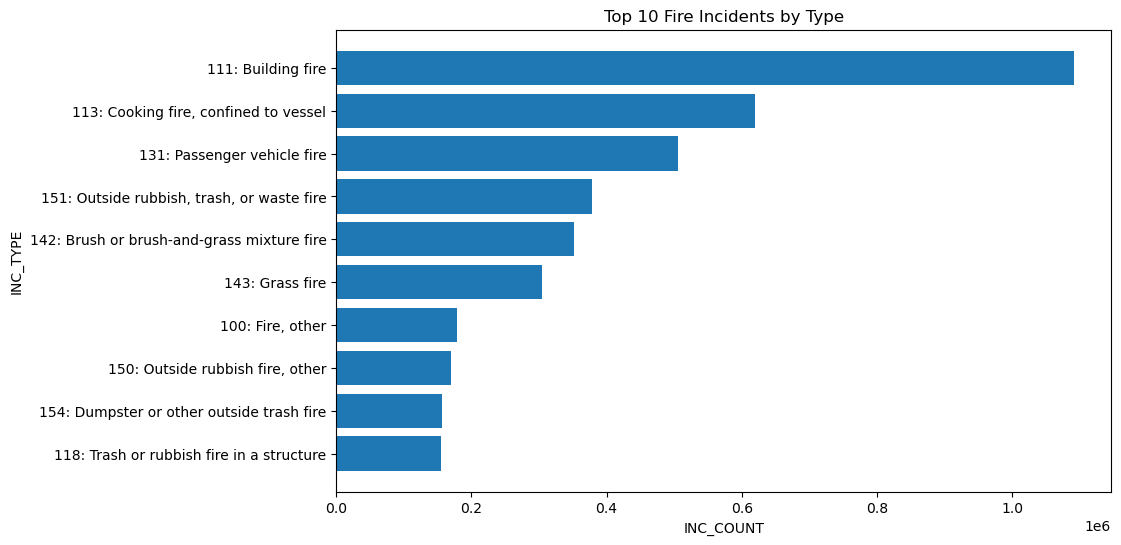

In [11]:
grouped_data = by_incident_type \
    .groupby('INC_TYPE')['INC_COUNT'] \
    .sum() \
    .reset_index()
sorted_data = grouped_data.sort_values('INC_COUNT', ascending=False)

# Avoid copy warning
top_10 = sorted_data.head(10).copy()

descriptions = {
    111: 'Building fire',
    113: 'Cooking fire, confined to vessel',
    131: 'Passenger vehicle fire',
    151: 'Outside rubbish, trash, or waste fire',
    142: 'Brush or brush-and-grass mixture fire',
    143: 'Grass fire',
    150: 'Outside rubbish fire, other',
    100: 'Fire, other',
    118: 'Trash or rubbish fire in a structure',
    154: 'Dumpster or other outside trash fire',
}

top_10.loc[:, 'INC_TYPE_DESC'] = top_10['INC_TYPE'].map(descriptions)
top_10.loc[:, 'INC_TYPE_WITH_DESC'] = top_10['INC_TYPE'].astype(str) + ': ' + top_10['INC_TYPE_DESC']

top_10 = top_10.sort_values('INC_COUNT', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_10['INC_TYPE_WITH_DESC'], top_10['INC_COUNT'])
plt.xlabel('INC_COUNT')
plt.ylabel('INC_TYPE')
plt.title('Top 10 Fire Incidents by Type')
plt.show()

Let's get total incident counts for each city for each of the top five types of incidents.

In [12]:
incident_types = [111, 113, 131, 151, 142]

top_5 = by_incident_type[by_incident_type['INC_TYPE'].isin(incident_types)].pivot_table(
    index=['CITYSTATE'], columns='INC_TYPE', values='INC_COUNT', fill_value=0
)

top_5.reset_index(inplace=True)
top_5.columns = top_5.columns.to_flat_index()

top_5.columns = [
    'CITYSTATE', 
    'COUNT_111', 
    'COUNT_113', 
    'COUNT_131', 
    'COUNT_151', 
    'COUNT_142'
]
top_5.sample(n=3, random_state=1)

,CITYSTATE,COUNT_111,COUNT_113,COUNT_131,COUNT_151,COUNT_142
4703,"MILL VALLEY,CA",172,54,29,19,5
7184,"THIEF RIVER FALLS,MN",59,9,45,19,15
6222,"ROCK HALL,MD",73,11,4,16,6


Now let's export for future analysis.

In [13]:
top_5.to_csv(
    WORKING_DIRECTORY + 'processed/top_5_incident_count.csv',
    sep=',',
    index=False
)